<a href="https://colab.research.google.com/github/aamish007/23-CS-006-CS318-DL-Lab/blob/main/23_CS_006_EXPERIMENT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully Connected Neural Network from Scratch (MNIST)

This notebook implements a fully connected neural network from scratch using NumPy, with PyTorch used only for loading the MNIST dataset. The model performs digit classification using manual forward and backpropagation, Cross-Entropy loss, and gradient descent. Training and validation performance are evaluated across epochs, with experiments on different network architectures and activation functions.

In [1]:

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


## Load MNIST Dataset

In [2]:

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


## Helper Functions

In [3]:

def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2

def softmax(z):
    exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)


## Neural Network Class (NumPy)

In [4]:

class NeuralNetwork:
    def __init__(self, layer_sizes, activation="relu", lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.activation_name = activation

        self.weights = []
        self.biases = []
        self.zs = []
        self.activations = []

        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def activation(self, z):
        return {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}[self.activation_name](z)

    def activation_derivative(self, z):
        return {
            "relu": relu_derivative,
            "sigmoid": sigmoid_derivative,
            "tanh": tanh_derivative
        }[self.activation_name](z)

    def forward(self, X):
        self.activations = [X]
        self.zs = []

        for i in range(len(self.weights) - 1):
            z = X @ self.weights[i] + self.biases[i]
            X = self.activation(z)
            self.zs.append(z)
            self.activations.append(X)

        z_out = X @ self.weights[-1] + self.biases[-1]
        y_hat = softmax(z_out)
        self.zs.append(z_out)
        self.activations.append(y_hat)

        return y_hat

    def compute_loss(self, y_hat, y_true):
        return -np.mean(np.sum(y_true * np.log(y_hat + 1e-9), axis=1))

    def backward(self, y_true):
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        dB = [None]*len(self.biases)

        delta = self.activations[-1] - y_true
        dW[-1] = self.activations[-2].T @ delta / m
        dB[-1] = np.mean(delta, axis=0, keepdims=True)

        for i in reversed(range(len(self.weights)-1)):
            delta = (delta @ self.weights[i+1].T) * self.activation_derivative(self.zs[i])
            dW[i] = self.activations[i].T @ delta / m
            dB[i] = np.mean(delta, axis=0, keepdims=True)

        return dW, dB

    def update_parameters(self, dW, dB):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * dB[i]

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    def evaluate(self, loader):
        correct = total = 0
        loss = 0

        for images, labels in loader:
            images = images.cpu().numpy().reshape(images.shape[0], -1) / 255.0
            labels = labels.cpu().numpy()
            y_true = one_hot(labels)

            y_hat = self.forward(images)
            loss += self.compute_loss(y_hat, y_true)

            correct += np.sum(np.argmax(y_hat, axis=1) == labels)
            total += labels.shape[0]

        return loss / len(loader), correct / total


## Training Loop

In [5]:

def train(model, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        correct = total = 0
        loss_sum = 0

        for images, labels in train_loader:
            images = images.cpu().numpy().reshape(images.shape[0], -1) / 255.0
            labels = labels.cpu().numpy()
            y_true = one_hot(labels)

            y_hat = model.forward(images)
            loss = model.compute_loss(y_hat, y_true)
            dW, dB = model.backward(y_true)
            model.update_parameters(dW, dB)

            loss_sum += loss
            correct += np.sum(np.argmax(y_hat, axis=1) == labels)
            total += labels.shape[0]

        train_losses.append(loss_sum / len(train_loader))
        train_accs.append(correct / total)

        val_loss, val_acc = model.evaluate(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, train_accs, val_losses, val_accs


## Run Experiment

Epoch 1: Train Acc=0.1120, Val Acc=0.1135
Epoch 2: Train Acc=0.1124, Val Acc=0.1135
Epoch 3: Train Acc=0.1124, Val Acc=0.1135
Epoch 4: Train Acc=0.1124, Val Acc=0.1135
Epoch 5: Train Acc=0.1124, Val Acc=0.1135
Epoch 6: Train Acc=0.1124, Val Acc=0.1135
Epoch 7: Train Acc=0.1124, Val Acc=0.1135
Epoch 8: Train Acc=0.1124, Val Acc=0.1135
Epoch 9: Train Acc=0.1124, Val Acc=0.1135
Epoch 10: Train Acc=0.1124, Val Acc=0.1135


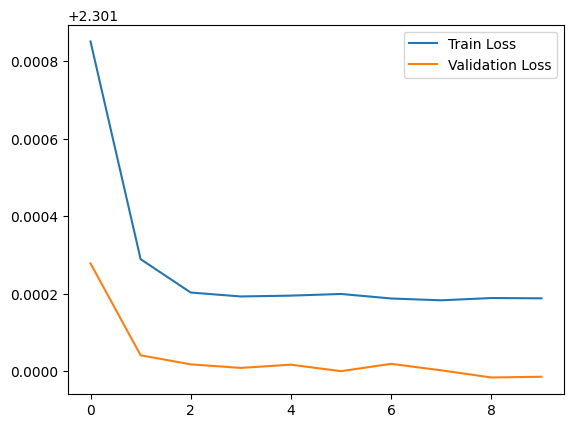

In [6]:

model = NeuralNetwork([784, 128, 10], activation="relu", lr=0.01)
train_losses, train_accs, val_losses, val_accs = train(model, epochs=10)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()
